# Q1. MachineLearning/DeepLearning Analysis   

>> background : 결측치 처리 완료함(Data_01_imputed_result.csv)
   #
1. Multi-task Learning (Multi-label Classification)   
당뇨 및 고혈압 유병 분류 문제에서 single-label을 고려하는 것이 아닌, 두 종류의 label을 함께 고려하는 multi-task learning (multi-label classification) 분석을 수행하기.
> single-label로 분석할 때와 비교.

2. 생체 나이 추정 모델   
동일 데이터에 대해 나이(AGE 변수)를 예측하는 모델로 태스크를 변경하여 생체 나이 추정 모형을 만들기.
> 이 과정에서 데이터의 구조가 어떻게 변화하는지 설명하고, 나이 예측 모델에 맞는 성능 지표의 결과를 제시하기

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score,hamming_loss

# 데이터 확인
import pandas as pd
data = pd.read_csv("./Data_01_imputed_result.csv")

# print(data.head())  # 데이터 일부 출력
# print(data.info())  # 데이터 정보 출력
# print(data.describe())  # 데이터 통계 정보 출력

In [ ]:
# 클래스 불균형 확인
print(data['Target_DM'].value_counts())
print(data['Target_HT'].value_counts())

---
## **📊 Flow1**   
> step01 : dataprocessing      
> - Target_DM(0,1), Target_HT(0,1) : [1,0] 당뇨 있고 고혈압 없음.
> - 두 레이블을 조합으로 하나의 열로 만들기
   #   
> setp02 : Multi-label 분류기 개발   
> - MLP based
   #
> setp03 : 평가 지표   
> - 개별 지표: 두 라벨에 대해 각각 Accuracy, F1-score, ROC-AUC
> - 전체 지표: hamming loss, exact match ratio
   #
> setp04 : 모델 비교 및 결과 분석   
> - Multi-task 모델 vs. 개별 Binary Classifier 비교
> - confusion matrix, ROC curve 등 시각화


---
> ## step01 : dataprocessing      
> - Target_DM(0,1), Target_HT(0,1) : [1,0] 당뇨 있고 고혈압 없음.
> - 두 레이블을 조합으로 하나의 열로 만들기

In [ ]:
# 데이터 확인
data = pd.read_csv("./Data_01_imputed_result.csv")
df = data.copy()

# 입력/타겟 변수
X = df.drop(columns=['Target_DM', 'Target_HT']).values  # 입력값
y = data[['Target_DM', 'Target_HT']].values


> ## setp02 : Multi-label classifier 설계
> - 단일 모델이 두 개의 출력을 예측함 (sigmoid 두 개)

In [ ]:
# 학습/테스트 분할 (멀티 라벨이므로 타겟도 같이 나눔)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# y_train에서 각각 레이블 분리
y_dm_train = y_train[:, 0]   # Target_DM
y_ht_train = y_train[:, 1]   # Target_HT

# y_dm_test = 
y_dm_test = y_test[:, 0]   # Target_DM
y_ht_test = y_test[:, 1]   # Target_HT

In [ ]:
from impute_model import *

classifier = MultiLabelClassifier(input_dim = X_train.shape[1])
classifier.model_train_fixed_hyperparameter(X_train,y_dm_train,y_ht_train)

> ## setp03 : 평가 지표   
> - 개별 지표: 두 라벨에 대해 각각 Accuracy, F1-score, ROC-AUC
> - 전체 지표: hamming loss, exact match ratio

In [ ]:
# 예측
device = 'cuda' if torch.cuda.is_available() else 'cpu'     # gpu 
if device!='cuda':
    raise RuntimeError("CUDA device not available. Please check if a GPU is available.")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

classifier.eval()
with torch.no_grad():
    pred_dm, pred_ht = classifier(X_test_tensor)
    pred_dm = pred_dm.squeeze().cpu().numpy()
    pred_ht = pred_ht.squeeze().cpu().numpy()
    
# 이진화 (threshold = 0.5)
pred_dm_binary = (pred_dm >= 0.5).astype(int)
pred_ht_binary = (pred_ht >= 0.5).astype(int)

# 개별 지표
print("📌 Target_DM Accuracy:", accuracy_score(y_dm_test, pred_dm_binary))
print("📌 Target_HT Accuracy:", accuracy_score(y_ht_test, pred_ht_binary))
print("📌 Target_DM F1:", f1_score(y_dm_test, pred_dm_binary))
print("📌 Target_HT F1:", f1_score(y_ht_test, pred_ht_binary))
print("📌 Target_DM AUC:", roc_auc_score(y_dm_test, pred_dm))
print("📌 Target_HT AUC:", roc_auc_score(y_ht_test, pred_ht))

| 지표               | Target_DM        | Target_HT        |
|--------------------|------------------|------------------|
| **Accuracy**       | 0.9567           | 0.8929           |
| **F1 Score**       | 0.1643           | 0.0047           |
| **AUC**            | 0.8864           | 0.8718           |
   #
결론:   
정확도는 두 레이블 모두 꽤 높은 성능을 보였으나, F1 점수가 매우 낮아서 불균형 클래스 문제나 다른 성능 지표에서 성능 저하가 있을 가능성이 큽니다.   
특히 Target_HT의 F1 점수가 매우 낮은 것은 고혈압 클래스에서 모델이 대부분의 예측을 **부정 클래스(0)**로만 하는 경향이 있을 수 있음을 나타냅니다.   

AUC는 두 레이블 모두 좋은 값을 보여 주며, 이는 모델이 양성 클래스(1)에 대해 잘 구분할 수 있음을 나타냅니다.

In [ ]:
# 전체 multi-label 지표
y_true = np.stack([y_dm_test, y_ht_test], axis=1)
y_pred_binary = np.stack([pred_dm_binary, pred_ht_binary], axis=1)

print("📌 Hamming Loss:", hamming_loss(y_true, y_pred_binary))
print("📌 Exact Match Ratio:", (y_true == y_pred_binary).all(axis=1).mean())

- Hamming Loss: 0.0752 ::: 다중 라벨 분류에서 잘못 예측된 라벨의 비율   :: 7.5% 잘못예측
- Exact Match Ratio: 0.866 :: 예측한 모든 라벨이 정확히 정답과 일치한 샘플의 비율 :: 86.6%정도 두 타켓을 모두 정확히 맞춤   

| 지표                    | 값               | 해석 요약                             |
|-------------------------|------------------|----------------------------------------|
| **Hamming Loss**        | 0.0752           | 잘못 예측한 라벨이 전체의 7.5%         |
| **Exact Match Ratio**   | 0.8663           | 두 라벨 모두 정확히 맞춘 샘플 비율 86.6% |


> ## setp04 : 모델 비교 및 결과 분석   
> - Multi-task 모델 vs. 개별 Binary Classifier 비교
> - confusion matrix, ROC curve 등 시각화

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score,hamming_loss

In [2]:
################## single label
# 데이터 확인
data = pd.read_csv("./Data_01_imputed_result.csv")
df = data.copy()

# 입력/타겟 변수 ::::::::::: single label target = Target_DM
X = df.drop(columns=['Target_DM', 'Target_HT']).values  # 입력값
y = data[['Target_DM']].values

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from impute_model import *

classifier = SingleLabelClassifier(input_dim = X_train.shape[1])
classifier.model_train_fixed_hyperparameter(X_train,y_train)

Epoch [1/20], Loss: 0.0219
Epoch [2/20], Loss: 0.0162
Epoch [3/20], Loss: 0.1585
Epoch [4/20], Loss: 0.0703
Epoch [5/20], Loss: 0.0186
Epoch [6/20], Loss: 0.0352
Epoch [7/20], Loss: 0.1518
Epoch [8/20], Loss: 0.0518
Epoch [9/20], Loss: 0.0609
Epoch [10/20], Loss: 0.0162
Epoch [11/20], Loss: 0.0382
Epoch [12/20], Loss: 0.0146
Epoch [13/20], Loss: 0.0640
Epoch [14/20], Loss: 0.2006
Epoch [15/20], Loss: 0.0106
Epoch [16/20], Loss: 0.0746
Epoch [17/20], Loss: 0.0812
Epoch [18/20], Loss: 0.1212
Epoch [19/20], Loss: 0.0495
Epoch [20/20], Loss: 0.3781


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

def evaluate_single_label_model_with_plots(model, X_test, y_test):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)

    # 입력 텐서
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        outputs = model(X_test_tensor)
        outputs = outputs.squeeze().cpu().numpy()

    preds_binary = (outputs >= 0.5).astype(int)
    y_true = y_test.ravel()

    # 평가 지표 출력
    print("📌 Accuracy:", accuracy_score(y_true, preds_binary))
    print("📌 F1 Score:", f1_score(y_true, preds_binary))
    print("📌 AUC:", roc_auc_score(y_true, outputs))
    print("\n📋 Classification Report:")
    print(classification_report(y_true, preds_binary, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, preds_binary)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("🔹 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, outputs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, outputs):.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("🔸 ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, outputs)
    plt.figure()
    plt.plot(recall, precision)
    plt.title("🟢 Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return preds_binary, outputs


📌 Accuracy: 0.9541927409261577
📌 F1 Score: 0.2591093117408907
📌 AUC: 0.8802516069472873

📋 Classification Report:
              precision    recall  f1-score   support

         0.0     0.9616    0.9916    0.9764      3812
         1.0     0.5000    0.1749    0.2591       183

    accuracy                         0.9542      3995
   macro avg     0.7308    0.5832    0.6177      3995
weighted avg     0.9404    0.9542    0.9435      3995



/tmp/ipykernel_1391460/3472959989.py:38: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


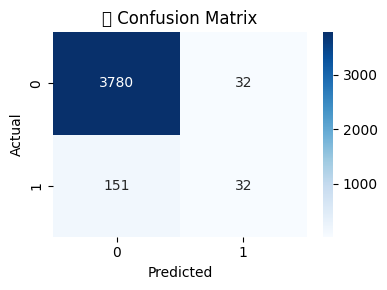

/tmp/ipykernel_1391460/3472959989.py:51: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


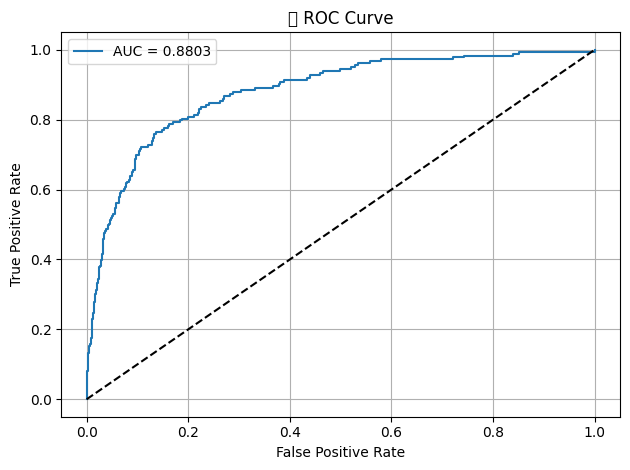

/tmp/ipykernel_1391460/3472959989.py:62: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


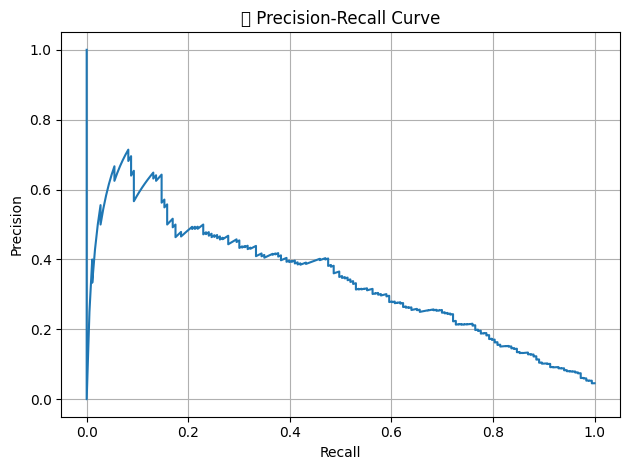

In [7]:
preds_binary, preds_prob = evaluate_single_label_model_with_plots(classifier, X_test, y_test)

---

### 🔍 Multi-task vs Single-label 성능 비교

| 지표                   | Multi-task 결과                     | Single-label (DM만) 결과         |
|------------------------|--------------------------------------|----------------------------------|
| **Accuracy**           | 95.67% (DM), 89.29% (HT)             | **95.42%** (DM)                  |
| **F1 Score**           | 0.16 (DM), 0.005 (HT)                | **0.2591** (DM)                  |
| **ROC AUC**            | 0.886 (DM), 0.872 (HT)               | **0.8803** (DM)                  |
| **Hamming Loss**       | 0.075                                | 해당 없음                        |
| **Exact Match Ratio**  | 0.866                                | 해당 없음                        |

---

### 📊 성능 비교 요약

#### ✅ Accuracy
- **Multi-task(DM)**: ███████████████████▊ 95.67%
- **Single-label(DM)**: ██████████████████▋ 95.42%

#### 🎯 F1 Score
- **Multi-task(DM)**: ███▍ 0.16
- **Single-label(DM)**: ██████▌ 0.259

#### 🧠 ROC AUC
- **Multi-task(DM)**: █████████████████ 0.886
- **Single-label(DM)**: ███████████████▉ 0.880

---

### 📌 해석 및 분석

- **Accuracy**는 두 모델 모두 높은 편으로, Single-label 분류가 약간 더 낮지만 비슷한 수준입니다.
- **F1 Score**에서는 Single-label 모델이 Multi-task보다 훨씬 우수하며, 특히 Positive 클래스(1.0)의 비율이 적은 불균형 데이터에서 중요한 지표입니다.
- **ROC AUC**는 두 모델 모두 양호하지만 Multi-task가 약간 더 높습니다.
- **Multi-task 모델**은 두 질병(DM, HT)을 동시에 예측하는 복합 모델로, 전체적인 예측 효율성과 다목적 활용에 유리합니다.
- 반면 **Single-label 모델**은 특정 질병(DM)에 대해서 더 정밀하게 예측하는 데 강점을 보입니다.

---

> 💡 **결론**: 다중 질병 예측이 필요한 상황에서는 Multi-task 모델이 유용하며, 단일 질병 예측의 정밀도를 높이고 싶다면 Single-label 모델을 병행 활용하는 것도 좋은 전략입니다.


---

---
## **📊 Flow2**   
> step01 : 문제 정의 및 흐름      
   #   
> setp02 : dataprocessing   
   #
> setp03 : 모델 설계& 모델 학습   
> - 회귀 모델
   #
> setp04 : 모델 평가 및 결과 분석   
   #
> setp05 : 모델 튜닝 및 최적화   
> - 하이퍼파라미터 튜닝, 교차 검증
   #
> setp06 : 정리 
